<a href="https://colab.research.google.com/github/dk-wei/ml-algo-implementation/blob/main/Ensemble_Learning_Classification_XGBoost_w_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data and Dependencies

In [ ]:
!pip install ipython-autotime
!pip install eli5
!pip install shap
%load_ext autotime

     |████████████████████████████████| 112kB 16.1MB/s 
     |████████████████████████████████| 358kB 19.4MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491614 sha256=b2f75e6d97eeec0d6891696c76de6713f8449758a2009f6f3653499553a1c9c6
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap
time: 2.41 ms (started: 2021-03-28 02:53:06 +00:00)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier

time: 964 ms (started: 2021-03-28 02:53:06 +00:00)


In [ ]:
plt.style.use('ggplot')
# load the dataset
column_names = ['age',
                'workclass',
                'fnlwgt',
                'education',
                'education-num',
                'marital-status',
                'occupation',
                'relationship',
                'race',
                'sex',
                'capital-gain',
                'capital-loss',
                'hours-per-week',
                'native-country',
                'high_income'
                ]

# df_purchase = pd.read_csv('purchase data.csv')

from google.colab import drive
drive.mount('/content/drive')

# Load the data, contained in the segmentation data csv file.
GD_PATH = '/content/drive/MyDrive/扬FAANG起航/单项准备/xgboost/'
#df_purchase = pd.read_csv(GD_PATH+'purchase data.csv', index_col = 0)

income = pd.read_csv(GD_PATH+"adult.data.csv", sep=",", names = column_names).head(1000)
income.info()

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1000 non-null   int64 
 1   workclass       1000 non-null   object
 2   fnlwgt          1000 non-null   int64 
 3   education       1000 non-null   object
 4   education-num   1000 non-null   int64 
 5   marital-status  1000 non-null   object
 6   occupation      1000 non-null   object
 7   relationship    1000 non-null   object
 8   race            1000 non-null   object
 9   sex             1000 non-null   object
 10  capital-gain    1000 non-null   int64 
 11  capital-loss    1000 non-null   int64 
 12  hours-per-week  1000 non-null   int64 
 13  native-country  1000 non-null   object
 14  high_income     1000 non-null   object
dtypes: int64(6), object(9)
memory usage: 117.3+ KB
time: 26.4 s (started: 2021-03-28 02:53:07 +00:00)


In [ ]:
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


time: 33 ms (started: 2021-03-28 02:53:33 +00:00)


# Data Processing Pipeline

In [ ]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]
# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!=' United-States','native-country'] = 'non_usa'
            df.loc[df['native-country']==' United-States','native-country'] = 'usa'
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        return df

time: 14.1 ms (started: 2021-03-28 02:53:33 +00:00)


In [ ]:
# Create the X feature matrix and the y target vector
X = income.drop(labels="high_income", axis=1)
y = income["high_income"]
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(y)
y = pd.Series(col.codes)
# global variables
seed = 108

time: 6.96 ms (started: 2021-03-28 02:53:33 +00:00)


In [ ]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]

# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),
]

# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

time: 20.9 ms (started: 2021-03-28 02:53:34 +00:00)


In [ ]:
# split-out train/validation and test dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)

time: 8.22 ms (started: 2021-03-28 02:53:34 +00:00)


In [ ]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', DecisionTreeClassifier(random_state=seed))
]

# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)

time: 5.61 ms (started: 2021-03-28 02:53:34 +00:00)


# Modeling

## Decision Tree

In [ ]:
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "model": [DecisionTreeClassifier(random_state=seed)],
    "model__criterion": ["gini","entropy"],
    "model__splitter": ["best","random"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__max_depth": np.linspace(1, 32, 32)
}

scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}

# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
n_iter=5
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)

# fit grid search
best_model = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


time: 2.43 s (started: 2021-03-28 02:53:34 +00:00)


In [ ]:
# final Decision Tree model
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.87875
Test Accuraccy:  0.81

Confusion Matrix:
[[141  13]
 [ 25  21]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       154
           1       0.62      0.46      0.52        46

    accuracy                           0.81       200
   macro avg       0.73      0.69      0.70       200
weighted avg       0.80      0.81      0.80       200

time: 31.5 ms (started: 2021-03-28 02:53:37 +00:00)


## Bagging Classifier

In [ ]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', BaggingClassifier(
        DecisionTreeClassifier(max_features="auto", splitter="random", max_leaf_nodes=128, random_state=seed),
        random_state=seed
    ))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid
param_grid = {
    "model": [BaggingClassifier(
        DecisionTreeClassifier(max_features="auto", splitter="random", max_leaf_nodes=128, random_state=seed),
        random_state=seed
    )],
    "model__n_estimators":  np.arange(100, 1000, 100),
    "model__max_samples":[0.8, 1.0], 
    "model__max_features": [0.8, 1.0],
    "model__bootstrap": [True],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
#n_iter=25
n_iter=5
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)
                                      
# fit grid search
best_bag = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


time: 32 s (started: 2021-03-28 02:53:37 +00:00)


In [ ]:
print(f'Best score: {best_bag.best_score_}')
print(f'Best model: {best_bag.best_params_}')

Best score: 0.8735454337412365
Best model: {'model__oob_score': True, 'model__n_estimators': 600, 'model__max_samples': 0.8, 'model__max_features': 0.8, 'model__bootstrap': True, 'model': BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=128,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                  

In [ ]:
pred_test = best_bag.predict(X_test)
pred_train = best_bag.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
#print("Out-of-Bag Accuracy: ", best_bag.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.97375
Test Accuraccy:  0.82

Confusion Matrix:
[[151   3]
 [ 33  13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.98      0.89       154
           1       0.81      0.28      0.42        46

    accuracy                           0.82       200
   macro avg       0.82      0.63      0.66       200
weighted avg       0.82      0.82      0.78       200

time: 197 ms (started: 2021-03-28 02:54:09 +00:00)


## Random Forest

In [ ]:
# we pass the preprocessing pipeline as a step to the full pipeline
full_pipeline_steps = [
    ('preprocessing_pipeline', preprocessing_pipeline),
    ('model', RandomForestClassifier(random_state=seed))
]
# create the full pipeline object
full_pipeline = Pipeline(steps=full_pipeline_steps)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "model": [RandomForestClassifier(random_state=seed)],
    "model__max_depth": np.linspace(1, 32, 32),
    "model__n_estimators": np.arange(100, 1000, 100),
    "model__criterion": ["gini","entropy"],
    "model__max_leaf_nodes": [16, 64, 128, 256],
    "model__oob_score": [True],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object with the full pipeline as estimator
#n_iter=50
n_iter=5
grid = RandomizedSearchCV(
    estimator=full_pipeline, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC"
)
# fit grid search
best_rf = grid.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


time: 49.3 s (started: 2021-03-28 02:54:09 +00:00)


In [ ]:
print(f'Best score: {best_rf.best_score_}')
print(f'Best model: {best_rf.best_params_}')

Best score: 0.8819446377268749
Best model: {'model__oob_score': True, 'model__n_estimators': 900, 'model__max_leaf_nodes': 128, 'model__max_depth': 6.0, 'model__criterion': 'gini', 'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6.0, max_features='auto',
                       max_leaf_nodes=128, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=900,
                       n_jobs=None, oob_score=True, random_state=108, verbose=0,
                       warm_start=False)}
time: 1.44 ms (started: 2021-03-28 02:54:58 +00:00)


In [ ]:
pred_test = best_rf.predict(X_test)
pred_train = best_rf.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
#print("Out-of-Bag Accuracy: ", best_rf.best_params_['model'].oob_score_)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.885
Test Accuraccy:  0.845

Confusion Matrix:
[[150   4]
 [ 27  19]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       154
           1       0.83      0.41      0.55        46

    accuracy                           0.84       200
   macro avg       0.84      0.69      0.73       200
weighted avg       0.84      0.84      0.82       200

time: 218 ms (started: 2021-03-28 02:54:58 +00:00)


In [ ]:
# clean_X = preprocessing_pipeline.fit_transform(X)

# clean_X_df = pd.DataFrame(clean_X, columns=X.columns)

# # split-out train/validation and test dataset
# X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)

time: 833 µs (started: 2021-03-28 02:54:58 +00:00)


In [ ]:
# lets get the random forest model configuration and feature names
#rf_model = best_rf.best_params_['model']
rf_model = best_rf
features = np.array(X_train.columns)
# Transforming the test data.
new_X_test = preprocessing_pipeline.fit_transform(X_test)
new_X_test = pd.DataFrame(new_X_test, columns=X_test.columns)
# get the predicitons from the random forest object
#rf_model.fit(X_train, y_train)
#rf_model = rf_model.fit(X_train,y_train)
y_pred = rf_model.predict(new_X_test)

time: 99.5 ms (started: 2021-03-28 02:54:58 +00:00)


In [ ]:
# best_rf is a sklearn pipeline object, if want to check feature importances, need to check steps

best_rf.best_estimator_.steps[1][1].feature_importances_

array([0.02171397, 0.04112047, 0.12748003, 0.03682509, 0.16419717,
       0.01272144, 0.01158386, 0.00444811, 0.11488864, 0.06089809,
       0.1734298 , 0.137026  , 0.02149167, 0.07217568])

time: 153 ms (started: 2021-03-28 02:54:59 +00:00)


Text(0, 0.5, 'Features')

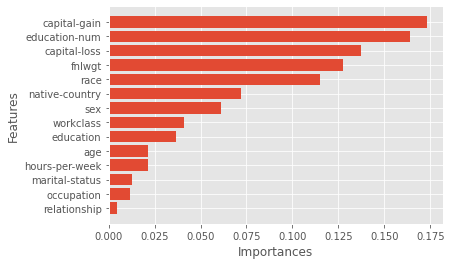

time: 313 ms (started: 2021-03-28 02:54:59 +00:00)


In [ ]:
# get the feature importances
importances = rf_model.best_estimator_.steps[1][1].feature_importances_
# sort the indexes
sorted_index = np.argsort(importances)
sorted_importances = importances[sorted_index]
sorted_features = features[sorted_index]
# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.barh(sorted_features , sorted_importances)
ax.set_xlabel('Importances')
ax.set_ylabel('Features')

In [ ]:
import eli5
# lets get the random forest model configuration and feature names
#rf_model = best_rf.best_params_['model']
features = np.array(X_train.columns)
eli5.show_weights(rf_model, feature_names=features)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


time: 1.42 s (started: 2021-03-28 02:54:59 +00:00)


In [ ]:
# predicting a person earns less than 50k/year (true negative)
index = 4
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)
# predicting a person earns more than 50k/year (true positive)
index = 7
print('Actual Label:', y_test.iloc[index])
print('Predicted Label:', y_pred[index])
eli5.explain_prediction(rf_model, new_X_test.iloc[index], feature_names=features)

Actual Label: 1
Predicted Label: 0
Actual Label: 0
Predicted Label: 0


Explanation(estimator="RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=108, shuffle=False),\n                   error_score=nan,\n                   estimator=Pipeline(memory=None,\n                                      steps=[('preprocessing_pipeline',\n                                              FeatureUnion(n_jobs=None,\n                                                           transformer_list=[('categorical_pipeline',\n                                                                              Pipeline(memory=None,\n                                                                                       steps=[('cat_selector',\n                                                                                               FeatureSelector(feature_names=['workclass',\n                                                                                                                              'education',\n                                                                                                                              'marital-status',\n                                                                                                                              'occu...\n       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,\n       27., 28., 29., 30., 31., 32.]),\n                                        'model__max_leaf_nodes': [16, 64, 128,\n                                                                  256],\n                                        'model__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),\n                                        'model__oob_score': [True]},\n                   pre_dispatch='2*n_jobs', random_state=None, refit='AUC',\n                   return_train_score=False,\n                   scoring={'AUC': 'roc_auc',\n                            'Accuracy': make_scorer(accuracy_score)},\n                   verbose=0)", description=None, error="estimator RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=108, shuffle=False),\n                   error_score=nan,\n                   estimator=Pipeline(memory=None,\n                                      steps=[('preprocessing_pipeline',\n                                              FeatureUnion(n_jobs=None,\n                                                           transformer_list=[('categorical_pipeline',\n                                                                              Pipeline(memory=None,\n                                                                                       steps=[('cat_selector',\n                                                                                               FeatureSelector(feature_names=['workclass',\n                                                                                                                              'education',\n                                                                                                                              'marital-status',\n                                                                                                                              'occu...\n       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,\n       27., 28., 29., 30., 31., 32.]),\n                                        'model__max_leaf_nodes': [16, 64, 128,\n                                                                  256],\n                                        'model__n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),\n                                        'model__oob_score': [True]},\n                   pre_dispatch='2*n_jobs', random_state=None, refit='AUC',\n                   return_train_score=False,\n                   scoring={'AUC': 'roc_auc',\n                            'Accuracy': make_scorer(accuracy_score)},\n                   verbose=0) is not supported", method=None, is_regression=False, targets=None, feature_importances=None, d

time: 140 ms (started: 2021-03-28 02:55:00 +00:00)


In [ ]:
import shap
shap.initjs()
# Create the explainer object
explainer = shap.TreeExplainer(rf_model.best_estimator_['model'])
print('Expected Value:', explainer.expected_value)
# get the shap values from the explainer
shap_values = explainer.shap_values(new_X_test)

Expected Value: [0.76761389 0.23238611]
time: 7.07 s (started: 2021-03-28 02:55:01 +00:00)


In [ ]:
shap.initjs()
# predicting a person earns less than 50k/year (true negative)
shap.force_plot(explainer.expected_value[0],
                shap_values[0][4], X_test.iloc[4])
# predicting a person earns more than 50k/year (true positive)
shap.force_plot(explainer.expected_value[1],
                shap_values[1][7], X_test.iloc[7])

time: 19.6 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
shap.initjs()

shap.force_plot(explainer.expected_value[0],
                shap_values[0][:1000,:], X_test.iloc[:1000,:])

time: 133 ms (started: 2021-03-28 02:55:08 +00:00)


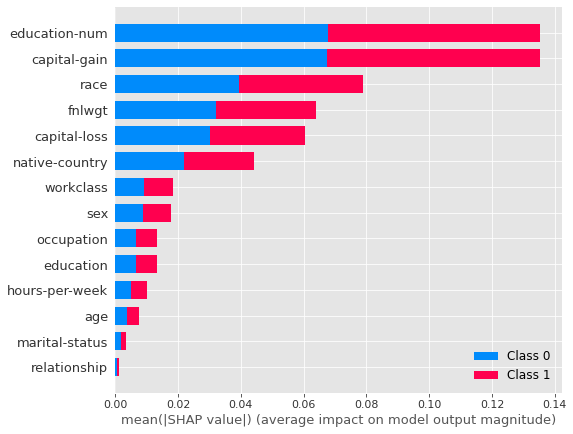

time: 359 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
shap.summary_plot(shap_values, X_test)

## XGBoost

Gradient Boosting is a type of ensemble method, much like `Bagging` and `Pasting`. However, Boosting differs from the previously mentioned methods in relation to how it does such a combination of models. It uses techniques to combine several weak learners into one strong learner.

While the other ensemble methods rely on the simultaneous construction of several isolated base learners that are then used to make the prediction, **Boosting algorithms rely on a sequential process, where each model attempts to correct the mistakes of previous models**. This leads to a major efficiency drawback, as the models are created one at a time and depend on the results obtained by previous iterations.

Gradient Boosting employs the gradient descent algorithm to minimize errors in sequential models. So, in essence, it is an optimization problem where the objective is to minimize the error (loss) function.

XGBoost (eXtreme Gradient Boosting), in its turn, is an optimized implementation of the Gradient Boosting algorithm. **It features (among other enhancements): parallelized tree building, cache-aware access, sparsity awareness, regularization (both L1 and L2), weighted quantile sketch**. The library has become one of the go-to solutions for winning many data science competitions in recent years.

In [ ]:
income.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


time: 34.6 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# Custom Transformer that extracts columns passed as argument
class FeatureSelector(BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__(self, feature_names):
        self.feature_names = feature_names
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        return X[self.feature_names]

# converts certain features to categorical
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes a boolean as its argument
    def __init__(self, new_features=True):
        self.new_features = new_features
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = X.copy()
        if self.new_features:
            # Treat ? workclass as unknown
            df['workclass']= df['workclass'].replace('?','Unknown') 
            # Two many category level, convert just US and Non-US
            df.loc[df['native-country']!=' United-States','native-country'] = 'non_usa'
            df.loc[df['native-country']==' United-States','native-country'] = 'usa'
        # convert columns to categorical
        for name in df.columns.to_list():
            col = pd.Categorical(df[name])
            df[name] = col.codes
        # returns numpy array
        print(df.columns)
        return df

time: 21.7 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# load the dataset
#income = pd.read_csv("income.csv")
# Create the X feature matrix and the y target vector
X = income.drop(labels=["high_income", 'fnlwgt'], axis=1)
#X = income.drop(labels=["high_income"], axis=1)
y = income["high_income"]
# the only step necessary to be done outside of pipeline
# convert the target column to categorical
col = pd.Categorical(y)
y = pd.Series(col.codes)

time: 4.49 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# get the categorical feature names
categorical_features = X.select_dtypes("object").columns.to_list()
# get the numerical feature names
numerical_features = X.select_dtypes("int64").columns.to_list()

# create the steps for the categorical pipeline
categorical_steps = [
    ('cat_selector', FeatureSelector(categorical_features)),
    ('cat_transformer', CategoricalTransformer())
]

# create the steps for the numerical pipeline
numerical_steps = [
    ('num_selector', FeatureSelector(numerical_features)),
    ('std_scaler', StandardScaler()),
]

# create the 2 pipelines with the respective steps
categorical_pipeline = Pipeline(categorical_steps)
numerical_pipeline = Pipeline(numerical_steps)

pipeline_list = [
    ('categorical_pipeline', categorical_pipeline),
    ('numerical_pipeline', numerical_pipeline)
]
# Combining the 2 pieplines horizontally into one full pipeline 
preprocessing_pipeline =FeatureUnion(transformer_list=pipeline_list)

time: 14.9 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# validate the preprocessing pipeline by passing data through it
clean_X = preprocessing_pipeline.fit_transform(X)

clean_X_df = pd.DataFrame(clean_X, columns=X.columns)
# split the clean_X into train and test sets
X_train, X_test, y_train, y_test = train_test_split(clean_X, y, test_size=0.20, random_state=seed, shuffle=True, stratify=y)

Index(['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'native-country'],
      dtype='object')
time: 20.8 ms (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# create a default XGBoost classifier
model = XGBClassifier(n_estimators=500, random_state=seed)
# define the eval set and metric
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
# fit the model
%time model.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=False)

CPU times: user 457 ms, sys: 162 ms, total: 619 ms
Wall time: 1.3 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=108,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

time: 1.31 s (started: 2021-03-28 02:55:08 +00:00)


In [ ]:
# final model assessment
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('Classification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.96625
Test Accuraccy:  0.86
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       154
           1       0.70      0.67      0.69        46

    accuracy                           0.86       200
   macro avg       0.80      0.79      0.80       200
weighted avg       0.86      0.86      0.86       200

time: 24.9 ms (started: 2021-03-28 02:55:10 +00:00)


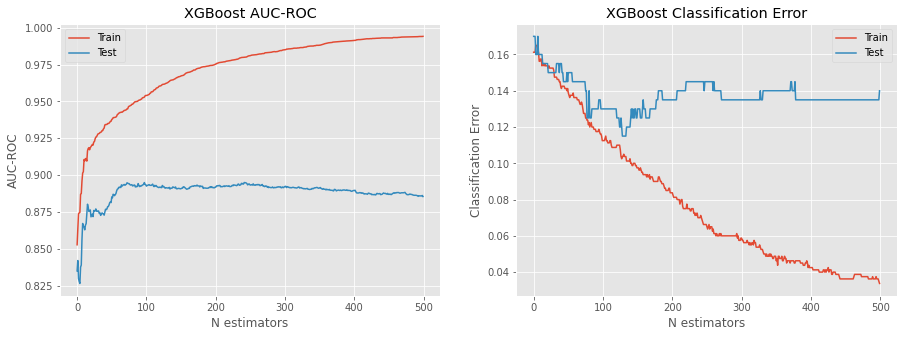

<Figure size 432x288 with 0 Axes>

time: 463 ms (started: 2021-03-28 02:55:10 +00:00)


In [ ]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 2, figsize=(15,5))
# plot auc
ax[0].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[0].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[0].legend()
ax[0].set_title('XGBoost AUC-ROC')
ax[0].set_ylabel('AUC-ROC')
ax[0].set_xlabel('N estimators')
# plot classification error
ax[1].plot(x_axis, results['validation_0']['error'], label='Train')
ax[1].plot(x_axis, results['validation_1']['error'], label='Test')
ax[1].legend()
ax[1].set_title('XGBoost Classification Error')
ax[1].set_ylabel('Classification Error')
ax[1].set_xlabel('N estimators')
plt.show()
plt.tight_layout()

Well, it looks like our model is performing fine until about 100 estimators, then the error on the train set continues to drop while the error on the test set more or less remains stable. That might be a sign of overfitting! One way to avoid this is by using the `early_stopping_rounds` parameter to stop execution once no improvement is observed after a specified number of rounds.

### XGBoost Parameter Tuning by using `RandomizedSearchCV`

**General parameters**:
hyperparameters that control the overall functioning of the algorithm;

- `booster`: `gbtree`, Which booster to use
- `nthread`: Number of parallel threads used to run XGBoost.

**Parameters for Tree Booster**: hyperparameters that control the individual boosters (tree or regression) at each step of the algorithm;
- `gamma`: a threshold that minimum loss reduction required to make a further partition on a leaf node of the tree. 
- `eta`: Step size shrinkage used in update to prevents overfitting.
- `lambda`: L2 regularization term on weights. Increasing this value will make model more conservative.
- `alpha`: L1 regularization term on weights. Increasing this value will make model more conservative.
- `max_depth`: `12`, Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- `subsample`: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 每次训练随机抽取样本(row)个数
- `colsample_bytree`: specify the fraction of columns to be subsampled. 每次训练随机抽取特征(col)个数


**Parameters for controlling over-fitting**:
- `max_depth`: `12`, Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- `eta` or `learning_rate`: Step size shrinkage used in update to prevents overfitting.
- `min_child_weight`: Minimum sum of instance weight (hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning. 

**Parameters for controlling training speed**:
- `colsample_bytree`: specify the fraction of columns to be subsampled. 每次训练随机抽取特征(col)个数
- `subsample`: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. 每次训练随机抽取样本(row)个数
- `n_estimators`:  Number of gradient boosted trees. Equivalent to number of boosting rounds. 决策树数目

In [ ]:
# create a default XGBoost classifier
model = XGBClassifier(
    random_state=seed, 
    eval_metric=["error", "auc"]
)
# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=5
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model = grid.fit(X_train,y_train)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


CPU times: user 337 ms, sys: 11.1 ms, total: 348 ms
Wall time: 6.54 s
time: 6.55 s (started: 2021-03-28 02:55:10 +00:00)


In [ ]:
print(f'Best score: {best_model.best_score_}')
print(f'Best model: {best_model.best_params_}')

Best score: 0.8958993972680686
Best model: {'subsample': 0.6, 'reg_lambda': 1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.6}
time: 1.03 ms (started: 2021-03-28 02:55:17 +00:00)


In [ ]:
pred_test = best_model.predict(X_test)
pred_train = best_model.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.855
Test Accuraccy:  0.855

Confusion Matrix:
[[147   7]
 [ 22  24]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       154
           1       0.77      0.52      0.62        46

    accuracy                           0.85       200
   macro avg       0.82      0.74      0.77       200
weighted avg       0.85      0.85      0.84       200

time: 20 ms (started: 2021-03-28 02:55:17 +00:00)


### Leverage GPU

In [ ]:
# create a default XGBoost classifier
# model = XGBClassifier(
#     random_state=seed, 
#     eval_metric=["error", "auc"]
# )

model = XGBClassifier(
    tree_method = "gpu_hist", 
    random_state=seed, 
    eval_metric=["error", "auc"]
)

# Create the grid search parameter grid and scoring funcitons
param_grid = {
    "learning_rate": [0.1, 0.01],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "subsample": [0.6, 0.8, 1.0],
    "max_depth": [2, 3, 4],
    "n_estimators": [100, 200, 300, 400],
    "reg_lambda": [1, 1.5, 2],
    "gamma": [0, 0.1, 0.3],
}
scoring = {
    'AUC': 'roc_auc', 
    'Accuracy': make_scorer(accuracy_score)
}
# create the Kfold object
num_folds = 10
kfold = StratifiedKFold(n_splits=num_folds, random_state=seed)
# create the grid search object
n_iter=5
grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=kfold,
    scoring=scoring,
    n_jobs=-1,
    n_iter=n_iter,
    refit="AUC",
)
# fit grid search
%time best_model_gpu = grid.fit(X_train,y_train)

Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.


CPU times: user 1.29 s, sys: 738 ms, total: 2.03 s
Wall time: 1min 12s
time: 1min 12s (started: 2021-03-28 02:55:17 +00:00)


In [ ]:
print(f'Best score: {best_model_gpu.best_score_}')
print(f'Best model: {best_model_gpu.best_params_}')

Best score: 0.8958215044485882
Best model: {'subsample': 1.0, 'reg_lambda': 2, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.6}
time: 3.21 ms (started: 2021-03-28 02:56:30 +00:00)


In [ ]:
pred_test = best_model_gpu.predict(X_test)
pred_train = best_model_gpu.predict(X_train)
print('Train Accuracy: ', accuracy_score(y_train, pred_train))
print('Test Accuraccy: ', accuracy_score(y_test, pred_test))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test,pred_test))
print('\nClassification Report:')
print(classification_report(y_test,pred_test))

Train Accuracy:  0.85875
Test Accuraccy:  0.86

Confusion Matrix:
[[147   7]
 [ 21  25]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91       154
           1       0.78      0.54      0.64        46

    accuracy                           0.86       200
   macro avg       0.83      0.75      0.78       200
weighted avg       0.85      0.86      0.85       200

time: 15.7 ms (started: 2021-03-28 02:56:30 +00:00)


In [ ]:
model = XGBClassifier(
    tree_method = "gpu_hist", 
    random_state=seed, 
    eval_metric=["error", "auc"]
)

time: 1.7 ms (started: 2021-03-28 02:56:30 +00:00)


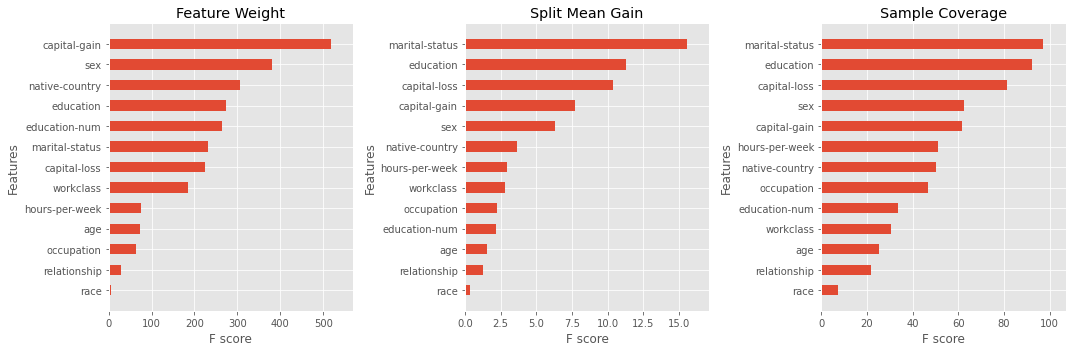

time: 638 ms (started: 2021-03-28 02:56:30 +00:00)


In [ ]:
# store the winning model in a new variable
xgc = best_model_gpu.best_estimator_
# saving the feature names to the model
xgc.get_booster().feature_names = X.columns.to_list()
# Create the feature importances plot
fig, ax = plt.subplots(1, 3, figsize=(15,5))
# plot importances with feature weight
xgb.plot_importance(
    booster=xgc, 
    importance_type='weight',
    title='Feature Weight',
    show_values=False,
    height=0.5,
    ax=ax[0],
)
# plot importances with split mean gain
xgb.plot_importance(
    booster=xgc,
    importance_type='gain',
    title='Split Mean Gain',
    show_values=False,
    height=0.5,
    ax=ax[1]
)
# plot importances with sample coverage
xgb.plot_importance(
    xgc,
    importance_type='cover',
    title='Sample Coverage',
    show_values=False,
    height=0.5,
    ax=ax[2]
)
plt.tight_layout()
plt.show()

- Feature Weights: the score is calculated based on the number of times the feature appears in the trees
- Gain: the score is calculated based on the average gain of splits which use the feature
- Coverage: the score is calculated based on the average coverage

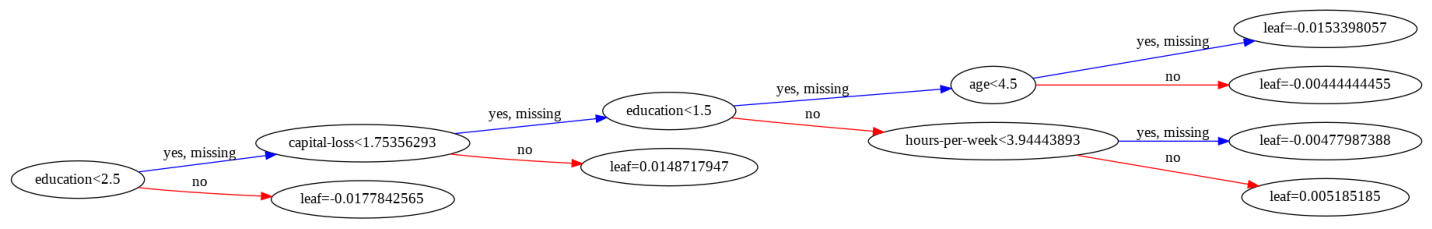

time: 449 ms (started: 2021-03-28 02:56:30 +00:00)


In [ ]:
# Create the feature importances plot
fig, ax = plt.subplots(figsize=(20,20))
# plot a decision tree from the booster
xgb.plot_tree(booster=xgc, num_trees=0, ax=ax, rankdir='LR')
plt.tight_layout()
plt.show()